# Trainining and Validation Datasets & losses

Prepare de dataset for training 
Calculate losses


Process:

- Tokenize the datasets
- Divide datasets into "chunks" os user specified sizes
- shuffle the rows and organize batches 
- this will be fed to the training process

In [1]:
import torch

import myllm.gpt as gpt
import myllm.data as data
import myllm.util
import tiktoken


In [2]:
# initializations

tokenizer = tiktoken.get_encoding("gpt2")

# to reduce complexity for trainig

gpt_config = gpt.GPT_CONFIG_124M
gpt_config["context_length"] = 256 # reduced to faster training
model = gpt.GPTModel(gpt_config)

In [3]:
# load vocabulary for learning purposes

file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("chars", total_characters)
print("tokens", total_tokens)

chars 20479
tokens 5145


In [4]:
# Generate both sets
train_ratio = 0.9 # 90% train / 10% validation
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [5]:
torch.manual_seed(123)

train_loader = data.create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=gpt_config["context_length"],
    stride=gpt_config["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = data.create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=gpt_config["context_length"],
    stride=gpt_config["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0 
)

print("Train loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation:
torch.Size([2, 256]) torch.Size([2, 256])


In [6]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [7]:
# compute training and validation loss
#1 Iteratives over all batches if no fixed num_batches is specified 
#2 Reduces the number of batches to match the total number of batches in the data loader if num_batches exceeds the number of batches in the data loader 
#3 Sums loss for each batch 
#4 Averages the loss over all batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if (len(data_loader)) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [8]:
# In action
# Determine to which compute unit to send
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

# approaching zero is a good thing
print("Training: ", train_loss)
print("Validation: ", val_loss)

Training:  11.00306224822998
Validation:  11.020950317382812


# Simple Traininig of a LLM Model
A typical training loop for training deep neural networks in PyTorch consists of numerous steps, iterating over the batches in the training set for several epochs. In each loop, we calculate the loss for each training set batch to determine loss gradients, which we use to update the model weights so that the training set loss is minimized.

From the book

In [9]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # evaluation step not training
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = myllm.util.text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = myllm.util.generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = myllm.util.token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

### Main Training Loop

In [10]:

def train_model_simple(model, train_loader, val_loader, 
                        optimizer, device, num_epochs,
                        eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0,-1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                # train model
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (step {global_step:06d}): "
                      f"Train loss {train_loss: .3f}"
                      f"Val loss {val_loss: .3f}"
                      )
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    
    return train_losses, val_losses, track_tokens_seen

In [11]:
# Fire in the hole!

torch.manual_seed(123)

model = gpt.GPTModel(gpt.GPT_CONFIG_124M)
model.to(device)

# common practice in Deep Learning is using an optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (step 000000): Train loss  9.778Val loss  9.927
Ep 1 (step 000005): Train loss  8.115Val loss  8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (step 000010): Train loss  6.665Val loss  7.044
Ep 2 (step 000015): Train loss  5.960Val loss  6.614
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (step 000020): Train loss  5.656Val loss  6.551
Ep 3 (step 000025): Train loss  5.360Val loss  6.370
Every effort moves you know parcel KokAPS public Patterns MuseAPS coral dying Forgottenznapesocyte. Gisburn, and's centresI stationed, and left Gisburn, and I had been saw Mrs. Gisburn, andburn, and Mrs. Gis
Ep 4 (step 000030): Train loss  5.099Val loss  6.328
Ep 4 (step 000035): Train loss  4.517Val loss  6.285
Every effort moves you know it's"I had been.                                          
Ep 5 (step 000040): Train loss  4.104Val loss  6.164
Every effo

### Plotting the Results
give me light!

It shows how the model is overfitting after epoch 2 - validation loss should be bellow training loss in real scenarios. This behavior is expected because of the dataset size

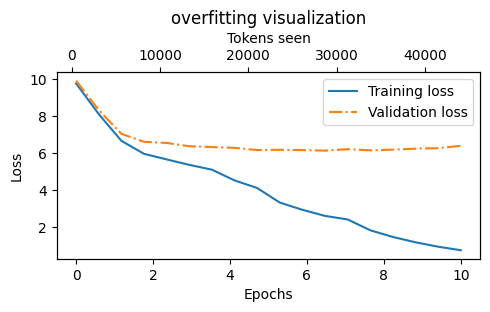

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                   #1
    ax2.plot(tokens_seen, train_losses, alpha=0)     #2
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.title('overfitting visualization')
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Text generation strategies

Model Memorization is a problem, meaning that the model is not generating properly the content. 

exploring strategies to mitigate this from happening

In [13]:

model.to('cpu')
# turn off random components like shortcut
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [14]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = myllm.util.generate_text_simple(
    model=model,
    idx = myllm.util.text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=25,
    context_size=gpt_config["context_length"]
)

# It will always generate the same output for the start text - called memorization
print("Output text: \n", myllm.util.token_ids_to_text(token_ids, tokenizer))

Output text: 
 Every effort moves you know," was not that my hostess was "interesting": on that point I could have given Miss Croft the fact,


### Temperature Scaling

adds probabilistic selection to next token, reducing the greedy decoding (generate text used argmax and always returns the highest prob)

we can add variety in the generation process replacing the argmax on the method 


In [15]:
# Probabilistic sampling example
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v:k for k,v in vocab.items()}

# example next token logits for "every effort moves you"
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item() # memorized max probability
print(inverse_vocab[next_token_id]) # forward

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])
# same result, but on average will be different 
# although 'forward' still most likely, it wont be selected always

forward
forward


In [16]:
# 1000 samplings 
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [ torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]

    sample_ids = torch.bincount(torch.tensor(sample))
    for i,freq in enumerate(sample_ids):
        print(f'{freq} x {inverse_vocab[i]}')

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [17]:
# temperature scaling is a way to mix this variety 
# based on a heat index (less crazy to more crazy)
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

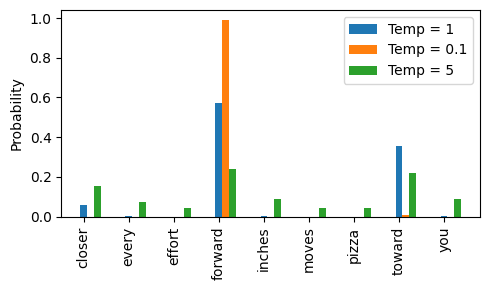

In [18]:
temperatures = [1,0.1,5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))
bar_width = 0.15
fig,ax = plt.subplots(figsize=(5,3))
for i,T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temp = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [19]:
for i,T in enumerate(temperatures):
    print(f'Temp = {T} ====')
    print_sampled_tokens(scaled_probas[i])
    

Temp = 1 ====
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
Temp = 0.1 ====
0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
Temp = 5 ====
165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


In [20]:
# how to see the prob of pizza on any distribution?
# we can look directly inside the tensor

temp5_idx = 2 
pizza_idx = 6

prob_tensor = scaled_probas[temp5_idx][pizza_idx]
print('probability tensor', prob_tensor)
print(f'There is a {prob_tensor.item()*100:.2f}% of the word pizza for temp 5')

probability tensor tensor(0.0430)
There is a 4.30% of the word pizza for temp 5


### Top-k sampling
Temperature scaling brings more 'creativity' to the next token prediction by making provabilities more uniformly distributed, but still gets you crazy results.

top-k with probabilistic sampling and temperature scaling can improve results, The idea is to restrict the samples tokens to the top-k and exclude the rest (like 'top-k = 3' means the first 3)


In [21]:
# get the top 3
top_k = 3

top_logits, top_pos = torch.topk(next_token_logits, top_k)
print('top', top_logits)
print('top k', top_pos)

top tensor([6.7500, 6.2800, 4.5100])
top k tensor([3, 7, 0])


In [22]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
# resulting logits using the small vocab
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [23]:
# softmax to get probabilities
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### Putting everything together
integrating temperature sampling and top-k

In [24]:
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:  
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,  -1]
            logits = torch.where( logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0: 
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id: break

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [25]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=myllm.util.text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=15,
    context_size=gpt_config["context_length"],
    top_k=25,
    temperature=1.4
)

print("output; \n", myllm.util.token_ids_to_text(token_ids, tokenizer))

output; 
 Every effort moves you can," was not that my friend in the deep arm- across the enough


In [26]:
# Moving generate to GPTModel
torch.manual_seed(123)
token_ids = model.generate(
    idx=myllm.util.text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=15,
    context_size=gpt_config["context_length"],
    top_k=25,
    temperature=1.4
)

print("output; \n", myllm.util.token_ids_to_text(token_ids, tokenizer))

output; 
 Every effort moves you can," was not that my friend in the deep arm- across the enough


### Saving model after pre training

yay

In [27]:
torch.save(model.state_dict(), 'model.pth')